# SVG File Parsing for Bézier Curve Extraction

## The goal of this section is to create a parser for our SVG files to more easily get the waypoints for each Bézier Curve in our SVG file so that we can use it to create a trajectory for our SketchBot.

## An Overview of SVG Files

SVG files describe vector graphics using paths. The paths are defined through the <path> element in SVG, and the 'd' attribute within the <path> element contains a string representing a series of commands and parameters that define the path.

The path data consists of commands such as:

M (Move To): Move the current point to a new position.
L (Line To): Draw a straight line from the current point to a new position.
C (Cubic Bezier Curve To): Draw a cubic Bézier curve.
Q (Quadratic Bezier Curve To): Draw a quadratic Bézier curve.
Z (Close Path): Close the current path by connecting the current point to the starting point.

Each of the commands above, depending on the SVG generator can have multiple aliases in the path detailed below:

MoveTo: M , m.
LineTo: L , l , H , h , V , v.
Cubic Bézier Curve: C , c , S , s.
Quadratic Bézier Curve: Q , q , T , t.
Elliptical Arc Curve: A , a.
ClosePath: Z , z.

## Our Parser

This notebook takes an SVG file as input and parses through the path element to get a representation of all the commands in a way that will allow us to extract the control points and generate Bezier Curves more easily than the format the raw file provides. I created this as I was not able to find any suitable Python library that parses through the SVG file we generated from the contours in the best way to extract all commands.

In [ ]:
!pip install svg.path

In [ ]:
#imports
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from svg.path import parse_path
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import sys 
import os
sys.path.append(os.path.abspath("/work/")) #for working in deepnote only
import curvature
from curvature import Curvature  #using https://github.com/MaciejPMarciniak/curvature

In [ ]:

def parse_svg(svg_file):
    '''
    Input: SVG_file containing line drawing of object
    Output: all the path data in a list of strings containing the commands for each (preparsing)
    '''
    tree = ET.parse(svg_file)
    root = tree.getroot()

    # Define the SVG namespace
    svg_namespace = {'svg': 'http://www.w3.org/2000/svg'}

    # Find all path elements in the SVG
    path_elements = root.findall('.//svg:path', namespaces=svg_namespace)
    print(path_elements)

    all_path_data = []
    # Iterate through each path element and extract the 'd' attribute (path data)
    for path_element in path_elements:
        path_data = path_element.get('d')
        all_path_data.append(path_data)

    return all_path_data

In [ ]:
def generate_reparsed_path(path_data):
    '''
    USE THIS FUNCTION IF WORKING WITH SVG FILE FROM CONTOURS
    Input: 
    path_data (List): path data from SVG file (processed with parse_svg) (normally just one instance, but in case we have a list)
    
    Output: 
    reparsed_path_data (List): A list of dictionaries with following entires (normally just one dict)
        path?_string (String): a string of the reparsed path with commands properly spaced, suitable for replotting with matplotlib
        MoveTo Commands (List): a list containing all the individual MoveTo or LineTo commands
        cubic commands  (List): a list containing all individual cubic bezier curve commands
        quadratic commands (List): a list containing all individual quadratic curve commands
    '''
    #list of all possible path commands 
    path_commands = ['M', 'm', 'L' , 'l' , 'H' , 'h' , 'V' , 'v', 'C', 'c', 'S', 's', 'Q', 'q', 'T', 't', 'A', 'a', 'Z', 'z']
    reparsed_path_data = {}

    re_parsed_path = ''
    move_to_commands = []
    cubic_commands = []
    quadratic_commands = []

    all_points = []
    #all_move_to_points = []

    for data in path_data:
        print(data)
        #due to the nature of the way SVG is formatted, we must reformat to be able to split better in python
        for command in path_commands:
            data = data.replace(command, ' '+command+' ') #to later parse and extract points from split on single character

        data = data.split()

        
        for i in range(len(data)): #iterate through the path and extract each command and their corresponding waypoints
            if 'M' in data[i]: #or 'L' in data[i]: #single point if MoveTo or LineTo command
                move_to_commands.append(data[i] + ' ' + data[i+1])
                re_parsed_path += data[i] + ' ' + data[i+1] + ' '
                
                point = (data[i+1].replace(',', ' '))
                all_points.append([float(point[0]), float(point[1])])
            
            elif 'C' in data[i]: #extract 3 points since cubic bezier curve
                
                cubic_command = data[i] + ' ' + data[i+1] + ', ' + data[i+2] + ', ' + data[i+3]
                cubic_commands.append(cubic_command)
                re_parsed_path += data[i] +' ' + data[i+1] + ',' + data[i+2] + ',' + data[i+3] + ' '

                for point in cubic_command.split()[1:]:
                    all_points.append([float(point.split(',')[0]), float(point.split(',')[1])])
                
            
            elif 'Q' in data[i]: #extract 2 points since quadratic bezier curve
                ##print('Q FOUND') for debugging
                quadratic_commands.append(data[i] + ' ' + data[i+1] + ', ' +  data[i+2])
                re_parsed_path += data[i] + ' ' + data[i+1] + ', ' +  data[i+2] + ' '
            #elif 
    reparsed_path_data = {'path string': re_parsed_path, 'MoveTo commands': move_to_commands, 'cubic commands':cubic_commands, 'quadratic commands': quadratic_commands}
    
    return reparsed_path_data, all_points



In [ ]:
#first we will load in the SVG file and extract the raw data from the path elements using parse_svg
path_data = parse_svg('out.svg')

#next we will generate the dictionaries containing all the commands and their associated waypoints
#generate_reparsed_path(path_data)

[<Element '{http://www.w3.org/2000/svg}path' at 0x7fdea59a4540>]


In [ ]:

def generate_reparsed_path_SAT(path_data):
    '''
    USE THIS FUNCTION IF WORKING WITH SAT FILE FROM TS
    Input: 
    path_data (List): path data from SVG file (processed with parse_svg) (normally just one instance, but in case we have a list)
    
    Output: 
    reparsed_path_data (List): A list of dictionaries with following entires (normally just one dict)
        path_string (String): a string of the reparsed path with commands properly spaced, suitable for replotting with matplotlib
        MoveTo Commands (List): a list containing all the individual MoveTo or LineTo commands
        cubic commands  (List): a list containing all individual cubic bezier curve commands
        quadratic commands (List): a list containing all individual quadratic curve commands
    '''
    #list of all possible path commands 
    path_commands = ['M', 'm', 'L' , 'l' , 'H' , 'h' , 'V' , 'v', 'C', 'c', 'S', 's', 'Q', 'q', 'T', 't', 'A', 'a', 'Z', 'z']
    reparsed_path_data = {}

    re_parsed_path = ''
    move_to_commands = []
    cubic_commands = []
    quadratic_commands = []

    all_moveto_points = []

    for data in path_data:

        #due to the nature of the way SVG is formatted, we must reformat to be able to split better in python
        for command in path_commands:
            data = data.replace(command, ' '+command+' ') #to later parse and extract points from split on single character

        data = data.split()
        #print(data)
        
        for i in range(len(data)): #iterate through the path and extract each command and their corresponding waypoints
            if 'M' in data[i]: # or 'L' in data[i]: #single point if MoveTo or LineTo command
                move_to_commands.append(data[i] + ' ' + data[i+1] + ' ' + data[i+2])  ##changing because different output of svg formatting for SAT file
                re_parsed_path += data[i] + ' ' + data[i+1] + ' ' + data[i+2] + ' '
                all_moveto_points.append([float(data[i+1]), float(data[i+2])])
            
            elif 'C' in data[i]: #extract 3 points since cubic bezier curve
                temp = ''
                for x in range(7):
                    temp += data[i+x] + ' '
                cubic_commands.append(temp)
                re_parsed_path += temp
            
            elif 'Q' in data[i]: #extract 2 points since quadratic bezier curve
                ##print('Q FOUND') for debugging
                temp = ''
                for x in range(5):
                    temp += data[i+x] + ' '
                quadratic_commands.append(temp)
                re_parsed_path += temp
            #elif 
    reparsed_path_data = {'path string': re_parsed_path, 'MoveTo commands': move_to_commands, 'cubic commands':cubic_commands, 'quadratic commands': quadratic_commands}
    
    return reparsed_path_data, all_moveto_points


### Example with generated bunny SVG file 

In [ ]:
#first we will load in the SVG file and extract the raw data from the path elements using parse_svg
path_data = parse_svg('out.svg')

#next we will generate the dictionaries containing all the commands and their associated waypoints
reparsed_data_original = generate_reparsed_path(path_data)
#print('Path String:', reparsed_data_original['path string'])
#print('MoveTo Commands', reparsed_data_original['MoveTo commands'])
#print('Cubic Commands', reparsed_data_original['cubic commands'])
#print('Quadratic Commands', reparsed_data_original['quadratic commands'])

[<Element '{http://www.w3.org/2000/svg}path' at 0x7fdea59a5d00>]
M377.0,462.3259077834862C372.4508362174215,461.5636073017164 369.00167639662396,459.780403309666 368.88151738159695,458.12867965644034C368.51124680613566,453.0388853747129 370.6172712188231,450.6830585972762 379.27175148277325,446.5060262950045C384.8767190179249,443.8008227780429 385.53202006121245,443.16589581475694 385.81996628246884,440.1614031934495C386.1768174094542,436.4379420094322 384.0503699835436,434.0858022378292 380.2785133808091,434.03180337187047C376.007841861576,433.9706633437067 367.0715037962185,429.1168070288138 359.12348218104216,422.54124862452863C352.34014186282104,416.9292545210606 350.7955272180784,415.06943029652734 349.0554333035657,410.4186125613211C346.60015520983853,403.8562938221238 346.3804322079433,394.61373112628195 348.5126138431632,387.5851228856037C349.33264473692043,384.8819404726857 349.8902738060185,382.5766698884931 349.75178955227,382.4622993651757C349.6133052985215,382.347928841858

### Now, with the reparsed data we can do stuff like this:

In the following cell, we will regenerate the curves using matplotlib

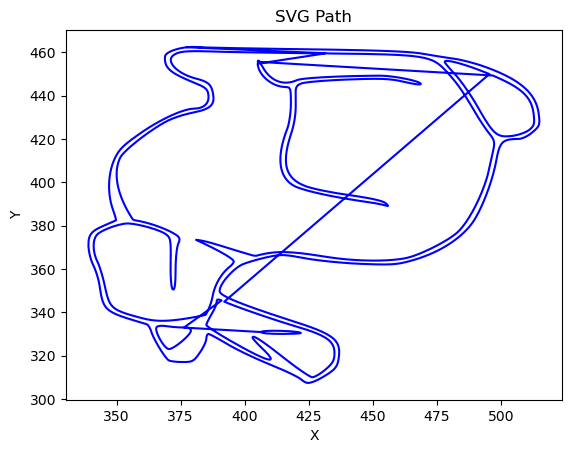

In [ ]:
def plot_svg_path(svg_path_data, num_points=2000):
    path = parse_path(svg_path_data)
    ##print(path) for debugging
    points = [path.point(i / num_points) for i in range(num_points + 1)]
    
    x, y = zip(*[(point.real, point.imag) for point in points])
    
    plt.plot(x, y, color='blue')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('SVG Path')
    plt.show()

#here we can directly import the Path String we generated above!
svg_path_data = reparsed_data_original[0]['path string']
plot_svg_path(svg_path_data)


## Further Processing: Medial Axis Transform (MAT) / Symmetry Axis Transform (SAT)

### Aiming to simplify multiple curves in SVG path to one for Trajectory

The notion of skeleton was introduced by H. Blum as a result of the Medial Axis Transform (MAT) or Symmetry Axis Transform (SAT). The MAT determines the closest boundary point(s) for each point in an object. An inner point belongs to the skeleton if it has at least two closest boundary points.

The SAT is similar to the MAT (and indeed uses it as input) but is often more practical as it removes insignificant MAT branches based on the local image scale. The culling severity of branches is controlled by a parameter called s.

<img src="Screenshot 2023-12-04 at 12.32.58.png" width="" align="" />

<img src="Screenshot 2023-12-04 at 12.29.44.png" width="" align="" />

### Original SVG contour image

### The grey silhouette is the original SVG shape and the blue curve is after SAT

In the rendering above to the right, the gray silhouette is the original SVG shape and the blue curves represent the SAT. On the left, we also see the original SVG output generated in the Contouri Pipeline notebook.

Potentially helpful: https://stackoverflow.com/questions/29921826/how-do-i-calculate-the-medial-axis-for-a-2d-vector-shape

We can access the standalone generated SVG of the MAT drawing here

Let us now process the curves of this modified SVG:

56595 455.33377220876184 476.55077154604675 455.722137321472 ', 'Q 476.450532411863 455.96605606855286 476.37071780229627 456.2368714136228 ', 'Q 476.39042286093866 456.2486019790809 476.4100724940895 456.2600797898 ', 'Q 476.55601703715604 456.3453294139507 476.699124718834 456.4167563225359 ', 'Q 477.0055204033076 456.569682400921 477.30371515298407 456.66128970244466 ', 'Q 477.6972415688497 456.7821834910672 478.12192093366946 456.8059045109629 ', 'Q 478.1359561894349 456.806688468482 478.15009194860073 456.80737686120176 ', 'Q 478.44976302445406 456.8219704450716 478.8254846303525 456.79309540120187 ', 'Q 478.85117268192715 456.7911212171132 478.8773405002368 456.7889412359879 ', 'Q 479.17511015759635 456.7641347265177 479.54533727526336 456.7115321639778 ', 'Q 479.56350657318995 456.7089506360862 479.58186950392644 456.70629994680496 ', 'Q 479.8814355856145 456.6630575791711 480.23728208324724 456.6006458264565 ', 'Q 480.3077658109364 456.5882837180412 480.380732836917 456.5751239

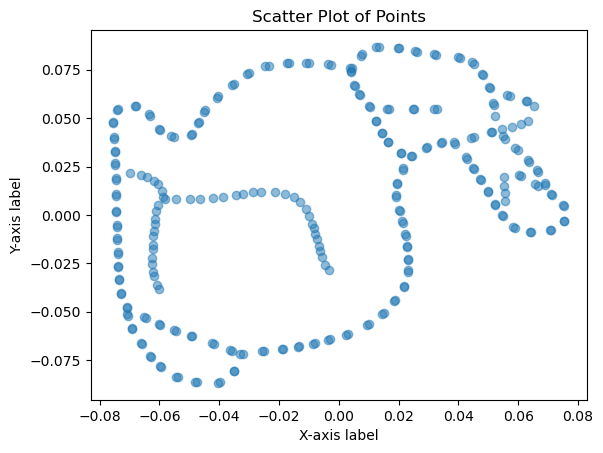

In [ ]:
path_data = parse_svg('extracted_sat.svg')
reparsed_data = generate_reparsed_path_SAT(path_data)
print('Path String:', reparsed_data[0]['path string'])
print('MoveTo Commands', reparsed_data[0]['MoveTo commands'])
print('Cubic Commands', reparsed_data[0]['cubic commands'])
print('Quadratic Commands', reparsed_data[0]['quadratic commands'])

move_to_points = reparsed_data[1]
print("Move to points", move_to_points)
print(len(move_to_points))
# Extract x and y coordinates from the 2D array
x_coords = [point[0] for i, point in enumerate(move_to_points) if i % 20 == 0]
y_coords = [point[1] for i, point in enumerate(move_to_points) if i % 20 == 0]

#Center the image at (0,0) and 
mid_y = (max(y_coords) - min(y_coords))/2 + min(y_coords)
mid_x = (max(x_coords) - min(x_coords))/2 + min(x_coords)

#flip about the x-axis by making all y coordinates negative
y_coords = [-(y - mid_y) for y in y_coords]
x_coords = [x - mid_x for x in x_coords]

#lastly, rotate 90 degrees clockwise (x,y) -> (y,-x) and scale by 0.001 for the scene
temp = x_coords
x_coords = [0.001 * i for i in y_coords]
y_coords = [0.001 * -i for i in temp]

new_points = [list(i) for i in zip(x_coords, y_coords)]

print(new_points)
print(len(new_points))

# Plot the points
plt.scatter(x_coords, y_coords,alpha=0.5)

# Add labels and title if needed
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter Plot of Points')

# Show the plot
plt.show()

#svg_path_data = reparsed_data['path string']
#plot_svg_path(svg_path_data)

In [ ]:
x_coords = [point[0]  for i, point in enumerate(new_points)]
y_coords = [point[1]  for i, point in enumerate(new_points)]

coordinates = [[x_coords[i], y_coords[i]] for i in range(len(x_coords))]


def map_coordinates_to_canvas(coordinates, frame_x, frame_y, frame_width, frame_height, canvas_width, canvas_height):
    # Calculate the scale factors for mapping from frame to canvas
    scale_x = canvas_width / frame_width 
    scale_y = canvas_height / frame_height  

    remapped_coordinates = []
    remapped_coordinates.append([0,0])
    remapped_coordinates.append([557*.001,0])
    remapped_coordinates.append([0,502*.001])
    remapped_coordinates.append([557*.001,502*.001])

    # Map the coordinates to the canvas
    for coordinate in coordinates:
        mapped_x = (((coordinate[0]) ) * .001)
        mapped_y = (((coordinate[1]) ) * .001)

        remapped_coordinates.append([mapped_x, mapped_y])
    
    return remapped_coordinates

# Example usage:
#get_svg_dimensions('extracted_sat.svg')
frame_x = 75
frame_y = 4
frame_width = 557
frame_height = 502

canvas_width = 480
canvas_height = 640

# Example coordinates in the frame
x_coordinate = 200
y_coordinate = 300

# Map coordinates to the canvas
remapped = map_coordinates_to_canvas(coordinates, frame_x, frame_y, frame_width, frame_height, canvas_width, canvas_height)

#print(f"Original Coordinates: ({x_coordinate}, {y_coordinate})")
#print(f"Mapped Coordinates: ({mapped_x}, {mapped_y})")


In [ ]:
print(remapped)

[[0, 0], [0.557, 0], [0, 0.502], [0.557, 0.502], [5.450722027252823e-05, 4.427407590614172e-05], [5.803957549579127e-05, 4.5498035721675025e-05], [6.319882469767117e-05, 4.872547861617119e-05], [6.523282968066388e-05, 5.6333308018271456e-05], [5.575236117519046e-05, 3.936589038248638e-05], [5.981913141901299e-05, 3.347293819965546e-05], [6.367431007561067e-05, 2.7520599600267475e-05], [6.67639632284816e-05, 2.2209583305836477e-05], [6.900232165301526e-05, 1.5401282215841832e-05], [7.135740643919376e-05, 1.0206661996950516e-05], [7.53970368673518e-05, 4.567293443519304e-06], [6.565631737465947e-05, 1.575995110789131e-05], [6.0419987279736234e-05, 2.0796661961479516e-05], [5.074872239365544e-05, 4.2759631649474955e-05], [4.429052603813904e-05, 3.976745564051413e-05], [3.90104266555992e-05, 3.6472794319364656e-05], [4.2800899407458595e-05, 2.9101704055839377e-05], [4.520332566165235e-05, 2.3534025539611945e-05], [4.7522494887841336e-05, 1.783265005721438e-05], [4.993233392255212e-05, 1.16

## Calculate Curvatures

Below we use the Menger curvature calculation, to extract the curvature between 3 consecutive points in our list of points that represent our drawing. We will then use this curvature calculation to determine areas to draw a thicker or thinner stroke, to enhance the artistic aesthetics of our drawing.

In [ ]:
#coordinates taken from last updated traj points in scene setup
#take coordinates and extract curvatures
#coordinates imported from traj_points in scene setup notebook

def generate_curvatures(points):
    x, y = zip(*points)
    xy = list(zip(x, y))  # list of points in 2D space
    curvatures = [0]

    curv = Curvature(line=xy)
    curv.calculate_curvature(gap=0)
    curvatures = [0]
    
    curvatures += list(curv.curvature) + [0] #[padding beginning and end with 0]

    mean = np.mean(curvatures)
    std_dev = np.std(curvatures)

    return curvatures, mean, std_dev


# default z value 0.175+0.015
#decrease z value to apply more pressure (more contact force, more width)
#increase z value to apply less pressure (less contact force, less width)
def generate_logistic_values( max_val, min_val, num_points):
    def logistic_function(x):
        return max_val - (max_val - min_val) / (1 + np.exp(-x))

    # Generate 10 values logistically decreasing to a minimum of 0.016 and then increasing back to 0.19
    x_values_decrease = np.linspace(-5, 5, num_points)
    logistic_values_decrease = [logistic_function(x) for x in x_values_decrease]

    # Reverse the list to create the increasing part
    logistic_values_increase = list(reversed(logistic_values_decrease))

    # Combine the decreasing and increasing parts
    logistic_values = logistic_values_decrease + logistic_values_increase[1:]

    return logistic_values


def generate_z_values(curvatures, logistic_values, mean_value, std_dev_value): #with 11 logistic coordinates
    z_values = [.19 for i in range(len(curvatures))]  #set this equal to coordinates
    for i in range(len(curvatures)):
        if i < 4 or i > (len(curvatures)-6): ##out of bounds cant insert list
            continue  
        if curvatures[i] >= (mean_value+std_dev_value/2) or curvatures[i] <= (mean_value-std_dev_value/2):
            z_values[i-4:i+5] = logistic_values ##extract 9 points before and 10 points after to insert regression vaulues into 
            #i += 4 #advance 3 
    return z_values


def test_generate_z_values(curvatures, logistic_values, mean_value, std_dev_value):
    z_values = [.019 for i in range(len(curvatures))]  #set this equal to coordinates
    for i in range(len(curvatures)):
        if i < 9 or i > (len(curvatures)-11): ##out of bounds cant insert list
            continue  
        if curvatures[i] >= (mean_value+std_dev_value/2) or curvatures[i] <= (mean_value-std_dev_value/2):
            z_values[i-9:i+10] = logistic_values ##extract 9 points before and 10 points after to insert regression vaulues into 
    return z_values

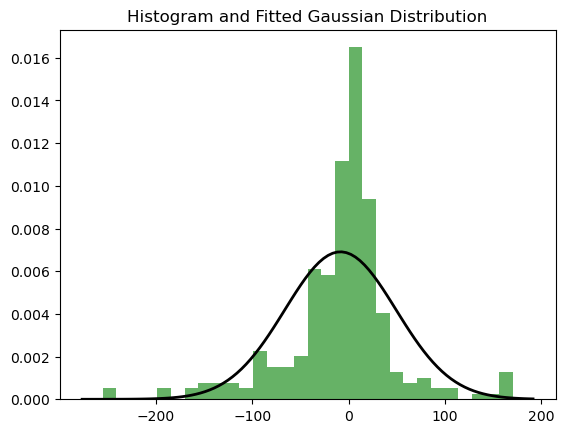

In [ ]:
#take coordinates and extract curvatures
#coordinates imported from traj_points in scene setup notebook
coordinates = [[0.1090083804456641, 0.0889050324634818, 0.019], [0.11607309089219019, 0.09135295209454841, 0.019], [0.12639158929594999, 0.09780783788354075, 0.019], [0.1304595992619354, 0.11302349668774127, 0.019], [0.11149866225098856, 0.07908866141617113, 0.18883544393917442], [0.11963220273863362, 0.06730275705050928, 0.18650998864241403], [0.12734256005182898, 0.05539807985173332, 0.18883544393917442], [0.13352186635757085, 0.044776047262871314, 0.18650998864241403], [0.13799858320663816, 0.031159445082882032, 0.17981457889986], [0.14270875277899517, 0.020770204645099398, 0.16235677575072077], [0.15078801363531125, 0.009491467538236976, 0.12656369931095476], [0.13130657464992657, 0.031876782866980986, 0.07943630068904525], [0.12126450172989235, 0.041516335295136285, 0.043643224249279244], [0.10189729922840866, 0.08605520737831762, 0.18883544393917442], [0.08956502472162982, 0.08026850225281146, 0.18883544393917442], [0.077139806316771, 0.0751451334020627, 0.18883544393917442], [0.08485810492635323, 0.060184504505502105, 0.18650998864241403], [0.08996376504679847, 0.04846981951745909, 0.17981457889986], [0.09447515038802828, 0.0374357843487353, 0.16235677575072077], [0.09947889379083892, 0.024639107345276672, 0.12656369931095476], [0.10441811690932377, 0.01139772050181, 0.07943630068904525], [0.109107659980363, -0.00014506207529257155, 0.043643224249279244], [0.11671089135459886, -0.012530642488388366, 0.02618542110014005], [0.12778828842239556, -0.017620104783416083, 0.01949001135758599], [0.1411099866291129, -0.015250333567423923, 0.017164556060825564], [0.1504226787996105, -0.005808502335463914, 0.01949001135758599], [0.06914993358006563, 0.07522134541225148, 0.02618542110014005], [0.05932302788812058, 0.07036408712197863, 0.043643224249279244], [0.04988664100880794, 0.06236656039833702, 0.07943630068904525], [0.043270061810342667, 0.04900663671613541, 0.12656369931095476], [0.039183132583765316, 0.03471896148678729, 0.16235677575072077], [0.03825841421148493, 0.020840064774536586, 0.17981457889986], [0.040395597212075925, 0.006545395583388313, 0.18650998864241403], [0.04243026483256585, -0.0053568018526300425, 0.18883544393917442], [0.04437804033541954, -0.018644725645372433, 0.019], [0.04562015983553352, -0.031493447372610374, 0.019], [0.04622338288118908, -0.044197642286075624, 0.019], [0.046197239802364495, -0.05663225197921167, 0.019], [0.04403997738683461, -0.07168972006831155, 0.019], [0.038348889933088576, -0.08632200392542938, 0.18883544393917442], [0.030176127169890835, -0.10047407328428529, 0.18883544393917442], [0.021299725658402963, -0.11164538456871628, 0.18650998864241403], [0.0065866258634590625, -0.12250651738103875, 0.17981457889986], [-0.005299498681799719, -0.1280438185863694, 0.16235677575072077], [-0.01554595537074465, -0.1319049249060673, 0.12656369931095476], [-0.02578533667395823, -0.13514549954114444, 0.07943630068904525], [-0.03616738989520502, -0.13780597252666257, 0.18883544393917442], [-0.049572916016316186, -0.14032906238751208, 0.18650998864241403], [-0.06263816927205722, -0.14298287841499463, 0.17981457889986], [-0.07024696073564735, -0.14121718975120304, 0.16235677575072077], [-0.08193316438230432, -0.13325184376596497, 0.12656369931095476], [-0.09634889293929541, -0.1258425615515256, 0.07943630068904525], [-0.10791035833329897, -0.1198996327246739, 0.043643224249279244], [-0.11866230356359836, -0.1136505295906519, 0.18883544393917442], [-0.12817479554606392, -0.1069797748522293, 0.18650998864241403], [-0.14056664941856092, -0.09922978100176828, 0.17981457889986], [-0.13896988323281925, -0.11447056785819813, 0.16235677575072077], [-0.13403558805940827, -0.12828111375086018, 0.12656369931095476], [-0.12702844512966044, -0.1433203318254998, 0.07943630068904525], [-0.120911823323401, -0.15374659839631966, 0.043643224249279244], [-0.11048443618917031, -0.1655634881847759, 0.02618542110014005], [-0.09876707437436653, -0.17170954428970867, 0.01949001135758599], [-0.08268182690428455, -0.17359622008285874, 0.017164556060825564], [-0.07120322155314261, -0.16348316016454556, 0.01949001135758599], [-0.14087134647620678, -0.09708621737440376, 0.02618542110014005], [-0.14510091313871432, -0.08273640622953042, 0.043643224249279244], [-0.1467041957569179, -0.0689112414546488, 0.07943630068904525], [-0.14743936502739644, -0.05557248827721583, 0.12656369931095476], [-0.1478795131420004, -0.04247417760955329, 0.16235677575072077], [-0.1482409106741404, -0.026728030158367118, 0.18883544393917442], [-0.14847400172290076, -0.013459254975218188, 0.18883544393917442], [-0.14869622172425376, 0.001010226651211724, 0.18883544393917442], [-0.14894519112061994, 0.01711355907588211, 0.18650998864241403], [-0.1492523581601031, 0.03478171769794449, 0.18883544393917442], [-0.1495559054920652, 0.050208623424130905, 0.18883544393917442], [-0.1498606413797586, 0.06375054250853385, 0.18650998864241403], [-0.15023392645417688, 0.07703650209818033, 0.17981457889986], [-0.15078801363531114, 0.09197940767062107, 0.16235677575072077], [-0.1492243477908121, 0.10599044843692014, 0.12656369931095476], [-0.13996442548647292, 0.11413781116614063, 0.07943630068904525], [-0.12868401741777996, 0.10627275268534686, 0.18883544393917442], [-0.12198094642780495, 0.09376002464667249, 0.18650998864241403], [-0.114568697794316, 0.0823059552498279, 0.17981457889986], [-0.10065829551049535, 0.08161838938742005, 0.16235677575072077], [-0.09462770142771354, 0.09067934156832314, 0.18883544393917442], [-0.0909259063525485, 0.10456667727736033, 0.18650998864241403], [-0.08450586581860842, 0.11722255799624452, 0.18883544393917442], [-0.07411433033381036, 0.1314902312589577, 0.18650998864241403], [-0.0633200299076625, 0.14369665971998496, 0.17981457889986], [-0.05283053233522253, 0.152247722818885, 0.16235677575072077], [-0.03888443319813439, 0.1565674740589741, 0.12656369931095476], [-0.02456874307737064, 0.15781387506359146, 0.18883544393917442], [-0.010725739167587449, 0.15682753579824488, 0.18650998864241403], [0.005087048761111192, 0.15331574761104844, 0.17981457889986], [0.013072396800716092, 0.16156899479926926, 0.18883544393917442], [0.021840270365208313, 0.17269340649664924, 0.18883544393917442], [0.03689708165542925, 0.17359622008285874, 0.18883544393917442], [0.04833050631589708, 0.1703361273748368, 0.18650998864241403], [0.061048955607853374, 0.16672759252246908, 0.17981457889986], [0.07491298945749213, 0.16430916533009657, 0.16235677575072077], [0.08682496001536322, 0.16026910592936383, 0.18883544393917442], [0.09443420691136475, 0.14948464488850835, 0.18883544393917442], [0.09926708264134482, 0.13610935477316696, 0.18650998864241403], [0.10779183270563704, 0.12553582603287441, 0.18883544393917442], [0.12174284161175285, 0.12024712730982072, 0.18883544393917442], [0.10293751698794472, 0.12034754294670484, 0.18650998864241403], [0.10422985177063242, 0.1054788020970774, 0.17981457889986], [0.00947709309719528, 0.13823731525078892, 0.16235677575072077], [0.012601967558637966, 0.1274826041461546, 0.12656369931095476], [0.017553161026877775, 0.1163306647454217, 0.07943630068904525], [0.02752399455327361, 0.10899312523315587, 0.043643224249279244], [0.043728770637871665, 0.10995362287178148, 0.02618542110014005], [0.058521735143603454, 0.11008875125707335, 0.01949001135758599], [0.04772366477414846, 0.06049722047492253, 0.017164556060825564], [0.0358157872930816, 0.07098636745543876, 0.18883544393917442], [0.03040657758270936, 0.08058613958000899, 0.18883544393917442], [0.026740650844472726, 0.09061680618602418, 0.18650998864241403], [0.024712543922007627, 0.09902738241187126, 0.17981457889986], [-0.008500025941540116, -0.05324182714382039, 0.16235677575072077], [-0.012673122424002486, -0.03476899430218009, 0.12656369931095476], [-0.0147386519985522, -0.02336876426852166, 0.18883544393917442], [-0.017066807023093135, -0.012287311607110383, 0.18883544393917442], [-0.02047095218798836, 0.0009871928341053718, 0.18650998864241403], [-0.02699457499654909, 0.01548703444002763, 0.17981457889986], [-0.03698676070904719, 0.022459157071202412, 0.16235677575072077], [-0.05426549280759162, 0.023955542334026633, 0.12656369931095476], [-0.06500942535591207, 0.022178829946498356, 0.07943630068904525], [-0.07886476527989339, 0.01850026257159186, 0.043643224249279244], [-0.09420510304768868, 0.016457289507088264, 0.02618542110014005], [-0.1104832155281623, 0.01645448345076318, 0.18883544393917442], [-0.12132868102725797, 0.00881292375409953, 0.18650998864241403], [-0.1229472171412483, -0.00499219592597251, 0.17981457889986], [-0.12381556255191686, -0.018093873844784752, 0.16235677575072077], [-0.12438829543990232, -0.031698562437036684, 0.12656369931095476], [-0.12472701368457945, -0.045864495179396156, 0.07943630068904525], [-0.12414038519664905, -0.05949649887370845, 0.18883544393917442], [-0.1213290377233709, -0.073000199119998, 0.18650998864241403], [-0.1177203075139181, 0.020675115747059068, 0.17981457889986], [-0.12148750899863717, 0.03279234406154308, 0.16235677575072077], [-0.1290746958770818, 0.0396075944831581, 0.12656369931095476], [0.11085159378498428, 0.0261605999035055, 0.07943630068904525], [0.11056076982420336, 0.0403237861761877, 0.043643224249279244], [0.11122763215243879, 0.012778975927996953, 0.02618542110014005], [0.12077432966358742, 0.09379529408762995, 0.01949001135758599], [0.1110111504053922, 0.07982119114631826, 0.18883544393917442], [0.11896374174630887, 0.06826440012176534, 0.18650998864241403], [0.12707629432519413, 0.05583275360737207, 0.18883544393917442], [0.13321905160977132, 0.045328063080132326, 0.18650998864241403], [0.13801136452957177, 0.03121584624300897, 0.17981457889986], [0.14253874401653924, 0.02101225300047315, 0.16235677575072077], [0.15069135467346054, 0.009618335841559997, 0.12656369931095476], [0.13185591590579668, 0.03143817568167458, 0.07943630068904525], [0.1216410535046041, 0.04113707316786486, 0.043643224249279244], [0.04637632105336343, 0.06111153162932783, 0.017164556060825564], [0.03503957170502861, 0.07214869896133962, 0.01949001135758599], [0.029936024669355903, 0.08162724526512875, 0.18883544393917442], [0.026475809959276262, 0.0916462174660577, 0.18883544393917442], [0.024526737545624542, 0.0998078620655723, 0.18650998864241403], [0.12942132598586353, 0.10146122151374891, 0.17981457889986], [-0.11178465933117616, 0.016488697204856864, 0.16235677575072077], [-0.09589288604275419, 0.0163754855625823, 0.12656369931095476], [-0.0801095841342975, 0.018229986647026523, 0.07943630068904525], [-0.06611422710400507, 0.021924934234940453, 0.043643224249279244], [-0.05529592119517088, 0.023848329771695945, 0.02618542110014005], [-0.03830672075641519, 0.02288544958943328, 0.01949001135758599], [-0.0279622043329681, 0.016615773245843457, 0.017164556060825564], [-0.020997264077063052, 0.0027330201188060527, 0.01949001135758599], [-0.017352691132271048, -0.011046795111068037, 0.02618542110014005], [-0.014950361647864839, -0.02227854631978255, 0.043643224249279244], [-0.01291140676444502, -0.033440696408031156, 0.07943630068904525], [-0.010629741522871883, -0.04535375695980997, 0.12656369931095476], [-0.11776552356095113, 0.016097734420905795, 0.16235677575072077], [-0.12231877093336811, 0.001699649737919799, 0.17981457889986], [-0.12340656460182242, -0.011214346753611836, 0.18650998864241403], [-0.12411703993419804, -0.02445905305646386, 0.18883544393917442], [-0.12456235666303132, -0.03742213476562074, 0.019], [-0.12468647492219487, -0.053123153091605445, 0.019], [-0.12297964832225466, -0.06626536847403282, 0.019], [-0.11977987270710355, -0.07888635523349422, 0.019], [-0.1186516174858847, 0.027460308422105072, 0.019], [-0.12489348297354684, 0.03652634432195612, 0.019], [-0.1349677238196091, 0.04226536088612284, 0.019], [0.11098769347015207, 0.019665997416581718, 0.019], [0.1107412867874482, 0.03272957489080216, 0.019]]
coordinates_without_z = [[coordinate[0], coordinate[1]] for coordinate in coordinates]

# Calculate statistics
##mean_value, median_value, std_dev_value = calculate_statistics(curvatures)

# Fit Gaussian distribution
#mu, sigma = fit_gaussian(#urvatures)


# Plot histogram and fitted Gaussian distribution
plt.hist(curvatures, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histogram and Fitted Gaussian Distribution")
plt.show()


In [ ]:
generate_logistic_values(.019, .004)

[0.018899607236135728,
 0.018699136951932243,
 0.01812194645688448,
 0.01661696342678627,
 0.01353135338887541,
 0.00946864661112459,
 0.006383036573213726,
 0.00487805354311552,
 0.004300863048067757,
 0.004100392763864272,
 0.004300863048067757,
 0.00487805354311552,
 0.006383036573213726,
 0.00946864661112459,
 0.01353135338887541,
 0.01661696342678627,
 0.01812194645688448,
 0.018699136951932243,
 0.018899607236135728]

In [ ]:
logistic_values[8]
z_values = [.019 for i in range(len(curvatures))]
len(z_values[30-9:30+10])


def generate_z_values(curvatures, logistic_values):
    z_values = [.019 for i in range(len(curvatures))]  #set this equal to coordinates
    for i in range(len(curvatures)):
        if i < 9 or i > (len(curvatures)-11): ##out of bounds cant insert list
            continue  
        if curvatures[i] >= (mean_value+std_dev_value) or curvatures[i] <= (mean_value-std_dev_value):
            z_values[i-9:i+10] = logistic_values ##extract 9 points before and 10 points after to insert regression vaulues into 
    return z_values

19

In [ ]:
list_of_segments = [[[0.1090083804456641, 0.0889050324634818], [0.11607309089219019, 0.09135295209454841], [0.12639158929594999, 0.09780783788354075], [0.1304595992619354, 0.11302349668774127]], [[0.11149866225098856, 0.07908866141617113], [0.11963220273863362, 0.06730275705050928], [0.12734256005182898, 0.05539807985173332], [0.13352186635757085, 0.044776047262871314], [0.13799858320663816, 0.031159445082882032], [0.14270875277899517, 0.020770204645099398], [0.15078801363531125, 0.009491467538236976]], [[0.13130657464992657, 0.031876782866980986], [0.12126450172989235, 0.041516335295136285]], [[0.10189729922840866, 0.08605520737831762], [0.08956502472162982, 0.08026850225281146], [0.077139806316771, 0.0751451334020627], [0.08485810492635323, 0.060184504505502105], [0.08996376504679847, 0.04846981951745909], [0.09447515038802828, 0.0374357843487353], [0.09947889379083892, 0.024639107345276672], [0.10441811690932377, 0.01139772050181], [0.109107659980363, -0.00014506207529257155], [0.11671089135459886, -0.012530642488388366], [0.12778828842239556, -0.017620104783416083], [0.1411099866291129, -0.015250333567423923], [0.1504226787996105, -0.005808502335463914]], [[0.06914993358006563, 0.07522134541225148], [0.05932302788812058, 0.07036408712197863], [0.04988664100880794, 0.06236656039833702], [0.043270061810342667, 0.04900663671613541], [0.039183132583765316, 0.03471896148678729], [0.03825841421148493, 0.020840064774536586], [0.040395597212075925, 0.006545395583388313], [0.04243026483256585, -0.0053568018526300425], [0.04437804033541954, -0.018644725645372433], [0.04562015983553352, -0.031493447372610374], [0.04622338288118908, -0.044197642286075624], [0.046197239802364495, -0.05663225197921167], [0.04403997738683461, -0.07168972006831155], [0.038348889933088576, -0.08632200392542938], [0.030176127169890835, -0.10047407328428529], [0.021299725658402963, -0.11164538456871628], [0.0065866258634590625, -0.12250651738103875], [-0.005299498681799719, -0.1280438185863694], [-0.01554595537074465, -0.1319049249060673], [-0.02578533667395823, -0.13514549954114444], [-0.03616738989520502, -0.13780597252666257], [-0.049572916016316186, -0.14032906238751208], [-0.06263816927205722, -0.14298287841499463], [-0.07024696073564735, -0.14121718975120304], [-0.08193316438230432, -0.13325184376596497], [-0.09634889293929541, -0.1258425615515256], [-0.10791035833329897, -0.1198996327246739], [-0.11866230356359836, -0.1136505295906519], [-0.12817479554606392, -0.1069797748522293], [-0.14056664941856092, -0.09922978100176828], [-0.13896988323281925, -0.11447056785819813], [-0.13403558805940827, -0.12828111375086018], [-0.12702844512966044, -0.1433203318254998], [-0.120911823323401, -0.15374659839631966], [-0.11048443618917031, -0.1655634881847759], [-0.09876707437436653, -0.17170954428970867], [-0.08268182690428455, -0.17359622008285874], [-0.07120322155314261, -0.16348316016454556]], [[-0.14087134647620678, -0.09708621737440376], [-0.14510091313871432, -0.08273640622953042], [-0.1467041957569179, -0.0689112414546488], [-0.14743936502739644, -0.05557248827721583], [-0.1478795131420004, -0.04247417760955329], [-0.1482409106741404, -0.026728030158367118], [-0.14847400172290076, -0.013459254975218188], [-0.14869622172425376, 0.001010226651211724], [-0.14894519112061994, 0.01711355907588211], [-0.1492523581601031, 0.03478171769794449], [-0.1495559054920652, 0.050208623424130905], [-0.1498606413797586, 0.06375054250853385], [-0.15023392645417688, 0.07703650209818033], [-0.15078801363531114, 0.09197940767062107], [-0.1492243477908121, 0.10599044843692014], [-0.13996442548647292, 0.11413781116614063], [-0.12868401741777996, 0.10627275268534686], [-0.12198094642780495, 0.09376002464667249], [-0.114568697794316, 0.0823059552498279], [-0.10065829551049535, 0.08161838938742005], [-0.09462770142771354, 0.09067934156832314], [-0.0909259063525485, 0.10456667727736033], [-0.08450586581860842, 0.11722255799624452], [-0.07411433033381036, 0.1314902312589577], [-0.0633200299076625, 0.14369665971998496], [-0.05283053233522253, 0.152247722818885], [-0.03888443319813439, 0.1565674740589741], [-0.02456874307737064, 0.15781387506359146], [-0.010725739167587449, 0.15682753579824488], [0.005087048761111192, 0.15331574761104844], [0.013072396800716092, 0.16156899479926926], [0.021840270365208313, 0.17269340649664924], [0.03689708165542925, 0.17359622008285874], [0.04833050631589708, 0.1703361273748368], [0.061048955607853374, 0.16672759252246908], [0.07491298945749213, 0.16430916533009657], [0.08682496001536322, 0.16026910592936383], [0.09443420691136475, 0.14948464488850835], [0.09926708264134482, 0.13610935477316696], [0.10779183270563704, 0.12553582603287441], [0.12174284161175285, 0.12024712730982072], [0.10293751698794472, 0.12034754294670484], [0.10422985177063242, 0.1054788020970774]], [[0.00947709309719528, 0.13823731525078892], [0.012601967558637966, 0.1274826041461546], [0.017553161026877775, 0.1163306647454217], [0.02752399455327361, 0.10899312523315587], [0.043728770637871665, 0.10995362287178148], [0.058521735143603454, 0.11008875125707335]], [[0.04772366477414846, 0.06049722047492253], [0.0358157872930816, 0.07098636745543876], [0.03040657758270936, 0.08058613958000899], [0.026740650844472726, 0.09061680618602418], [0.024712543922007627, 0.09902738241187126]], [[-0.008500025941540116, -0.05324182714382039], [-0.012673122424002486, -0.03476899430218009], [-0.0147386519985522, -0.02336876426852166], [-0.017066807023093135, -0.012287311607110383], [-0.02047095218798836, 0.0009871928341053718], [-0.02699457499654909, 0.01548703444002763], [-0.03698676070904719, 0.022459157071202412], [-0.05426549280759162, 0.023955542334026633], [-0.06500942535591207, 0.022178829946498356], [-0.07886476527989339, 0.01850026257159186], [-0.09420510304768868, 0.016457289507088264], [-0.1104832155281623, 0.01645448345076318], [-0.12132868102725797, 0.00881292375409953], [-0.1229472171412483, -0.00499219592597251], [-0.12381556255191686, -0.018093873844784752], [-0.12438829543990232, -0.031698562437036684], [-0.12472701368457945, -0.045864495179396156], [-0.12414038519664905, -0.05949649887370845], [-0.1213290377233709, -0.073000199119998]], [[-0.1177203075139181, 0.020675115747059068], [-0.12148750899863717, 0.03279234406154308], [-0.1290746958770818, 0.0396075944831581]], [[0.11085159378498428, 0.0261605999035055], [0.11056076982420336, 0.0403237861761877], [0.11122763215243879, 0.012778975927996953]]]
for segment in segments:
    

In [ ]:
z_values = generate_z_values(curvatures, logistic_values)
print((z_values))

[0.019, 0.019, 0.019, 0.019, 0.18875512972808303, 0.18626929820395982, 0.18875512972808303, 0.18626929820395982, 0.17911213606536758, 0.1604503464921498, 0.12218878202205509, 0.07181121797794492, 0.03354965350785022, 0.18875512972808303, 0.18875512972808303, 0.18875512972808303, 0.18626929820395982, 0.17911213606536758, 0.1604503464921498, 0.12218878202205509, 0.07181121797794492, 0.03354965350785022, 0.014887863934632428, 0.007730701796040185, 0.005244870271916974, 0.007730701796040185, 0.014887863934632428, 0.03354965350785022, 0.07181121797794492, 0.12218878202205509, 0.1604503464921498, 0.17911213606536758, 0.18626929820395982, 0.18875512972808303, 0.019, 0.019, 0.019, 0.019, 0.019, 0.18875512972808303, 0.18875512972808303, 0.18626929820395982, 0.17911213606536758, 0.1604503464921498, 0.12218878202205509, 0.07181121797794492, 0.18875512972808303, 0.18626929820395982, 0.17911213606536758, 0.1604503464921498, 0.12218878202205509, 0.07181121797794492, 0.03354965350785022, 0.1887551297

(0.1090083804456641, 0.11607309089219019, 0.12639158929594999, 0.1304595992619354, 0.11149866225098856, 0.11963220273863362, 0.12734256005182898, 0.13352186635757085, 0.13799858320663816, 0.14270875277899517, 0.15078801363531125, 0.13130657464992657, 0.12126450172989235, 0.10189729922840866, 0.08956502472162982, 0.077139806316771, 0.08485810492635323, 0.08996376504679847, 0.09447515038802828, 0.09947889379083892, 0.10441811690932377, 0.109107659980363, 0.11671089135459886, 0.12778828842239556, 0.1411099866291129, 0.1504226787996105, 0.06914993358006563, 0.05932302788812058, 0.04988664100880794, 0.043270061810342667, 0.039183132583765316, 0.03825841421148493, 0.040395597212075925, 0.04243026483256585, 0.04437804033541954, 0.04562015983553352, 0.04622338288118908, 0.046197239802364495, 0.04403997738683461, 0.038348889933088576, 0.030176127169890835, 0.021299725658402963, 0.0065866258634590625, -0.005299498681799719, -0.01554595537074465, -0.02578533667395823, -0.03616738989520502, -0.049

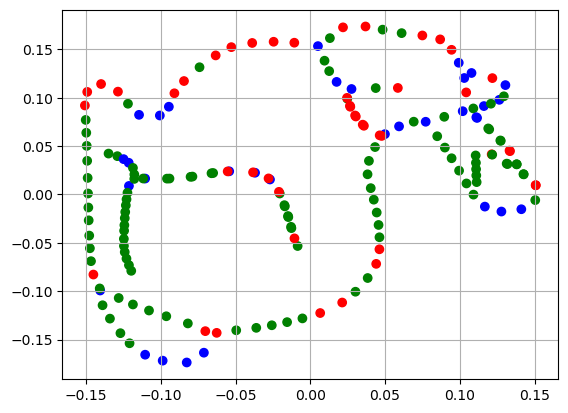

In [ ]:
# Function to map the colors as a list from the input list of x variables
##if coordinate mean + 2 standard deviation
##if coordinate mean = 
traj_points = [[0.1090083804456641, 0.0889050324634818], [0.11607309089219019, 0.09135295209454841], [0.12639158929594999, 0.09780783788354075], [0.1304595992619354, 0.11302349668774127], [0.11149866225098856, 0.07908866141617113], [0.11963220273863362, 0.06730275705050928], [0.12734256005182898, 0.05539807985173332], [0.13352186635757085, 0.044776047262871314], [0.13799858320663816, 0.031159445082882032], [0.14270875277899517, 0.020770204645099398], [0.15078801363531125, 0.009491467538236976], [0.13130657464992657, 0.031876782866980986], [0.12126450172989235, 0.041516335295136285], [0.10189729922840866, 0.08605520737831762], [0.08956502472162982, 0.08026850225281146], [0.077139806316771, 0.0751451334020627], [0.08485810492635323, 0.060184504505502105], [0.08996376504679847, 0.04846981951745909], [0.09447515038802828, 0.0374357843487353], [0.09947889379083892, 0.024639107345276672], [0.10441811690932377, 0.01139772050181], [0.109107659980363, -0.00014506207529257155], [0.11671089135459886, -0.012530642488388366], [0.12778828842239556, -0.017620104783416083], [0.1411099866291129, -0.015250333567423923], [0.1504226787996105, -0.005808502335463914], [0.06914993358006563, 0.07522134541225148], [0.05932302788812058, 0.07036408712197863], [0.04988664100880794, 0.06236656039833702], [0.043270061810342667, 0.04900663671613541], [0.039183132583765316, 0.03471896148678729], [0.03825841421148493, 0.020840064774536586], [0.040395597212075925, 0.006545395583388313], [0.04243026483256585, -0.0053568018526300425], [0.04437804033541954, -0.018644725645372433], [0.04562015983553352, -0.031493447372610374], [0.04622338288118908, -0.044197642286075624], [0.046197239802364495, -0.05663225197921167], [0.04403997738683461, -0.07168972006831155], [0.038348889933088576, -0.08632200392542938], [0.030176127169890835, -0.10047407328428529], [0.021299725658402963, -0.11164538456871628], [0.0065866258634590625, -0.12250651738103875], [-0.005299498681799719, -0.1280438185863694], [-0.01554595537074465, -0.1319049249060673], [-0.02578533667395823, -0.13514549954114444], [-0.03616738989520502, -0.13780597252666257], [-0.049572916016316186, -0.14032906238751208], [-0.06263816927205722, -0.14298287841499463], [-0.07024696073564735, -0.14121718975120304], [-0.08193316438230432, -0.13325184376596497], [-0.09634889293929541, -0.1258425615515256], [-0.10791035833329897, -0.1198996327246739], [-0.11866230356359836, -0.1136505295906519], [-0.12817479554606392, -0.1069797748522293], [-0.14056664941856092, -0.09922978100176828], [-0.13896988323281925, -0.11447056785819813], [-0.13403558805940827, -0.12828111375086018], [-0.12702844512966044, -0.1433203318254998], [-0.120911823323401, -0.15374659839631966], [-0.11048443618917031, -0.1655634881847759], [-0.09876707437436653, -0.17170954428970867], [-0.08268182690428455, -0.17359622008285874], [-0.07120322155314261, -0.16348316016454556], [-0.14087134647620678, -0.09708621737440376], [-0.14510091313871432, -0.08273640622953042], [-0.1467041957569179, -0.0689112414546488], [-0.14743936502739644, -0.05557248827721583], [-0.1478795131420004, -0.04247417760955329], [-0.1482409106741404, -0.026728030158367118], [-0.14847400172290076, -0.013459254975218188], [-0.14869622172425376, 0.001010226651211724], [-0.14894519112061994, 0.01711355907588211], [-0.1492523581601031, 0.03478171769794449], [-0.1495559054920652, 0.050208623424130905], [-0.1498606413797586, 0.06375054250853385], [-0.15023392645417688, 0.07703650209818033], [-0.15078801363531114, 0.09197940767062107], [-0.1492243477908121, 0.10599044843692014], [-0.13996442548647292, 0.11413781116614063], [-0.12868401741777996, 0.10627275268534686], [-0.12198094642780495, 0.09376002464667249], [-0.114568697794316, 0.0823059552498279], [-0.10065829551049535, 0.08161838938742005], [-0.09462770142771354, 0.09067934156832314], [-0.0909259063525485, 0.10456667727736033], [-0.08450586581860842, 0.11722255799624452], [-0.07411433033381036, 0.1314902312589577], [-0.0633200299076625, 0.14369665971998496], [-0.05283053233522253, 0.152247722818885], [-0.03888443319813439, 0.1565674740589741], [-0.02456874307737064, 0.15781387506359146], [-0.010725739167587449, 0.15682753579824488], [0.005087048761111192, 0.15331574761104844], [0.013072396800716092, 0.16156899479926926], [0.021840270365208313, 0.17269340649664924], [0.03689708165542925, 0.17359622008285874], [0.04833050631589708, 0.1703361273748368], [0.061048955607853374, 0.16672759252246908], [0.07491298945749213, 0.16430916533009657], [0.08682496001536322, 0.16026910592936383], [0.09443420691136475, 0.14948464488850835], [0.09926708264134482, 0.13610935477316696], [0.10779183270563704, 0.12553582603287441], [0.12174284161175285, 0.12024712730982072], [0.10293751698794472, 0.12034754294670484], [0.10422985177063242, 0.1054788020970774], [0.00947709309719528, 0.13823731525078892], [0.012601967558637966, 0.1274826041461546], [0.017553161026877775, 0.1163306647454217], [0.02752399455327361, 0.10899312523315587], [0.043728770637871665, 0.10995362287178148], [0.058521735143603454, 0.11008875125707335], [0.04772366477414846, 0.06049722047492253], [0.0358157872930816, 0.07098636745543876], [0.03040657758270936, 0.08058613958000899], [0.026740650844472726, 0.09061680618602418], [0.024712543922007627, 0.09902738241187126], [-0.008500025941540116, -0.05324182714382039], [-0.012673122424002486, -0.03476899430218009], [-0.0147386519985522, -0.02336876426852166], [-0.017066807023093135, -0.012287311607110383], [-0.02047095218798836, 0.0009871928341053718], [-0.02699457499654909, 0.01548703444002763], [-0.03698676070904719, 0.022459157071202412], [-0.05426549280759162, 0.023955542334026633], [-0.06500942535591207, 0.022178829946498356], [-0.07886476527989339, 0.01850026257159186], [-0.09420510304768868, 0.016457289507088264], [-0.1104832155281623, 0.01645448345076318], [-0.12132868102725797, 0.00881292375409953], [-0.1229472171412483, -0.00499219592597251], [-0.12381556255191686, -0.018093873844784752], [-0.12438829543990232, -0.031698562437036684], [-0.12472701368457945, -0.045864495179396156], [-0.12414038519664905, -0.05949649887370845], [-0.1213290377233709, -0.073000199119998], [-0.1177203075139181, 0.020675115747059068], [-0.12148750899863717, 0.03279234406154308], [-0.1290746958770818, 0.0396075944831581], [0.11085159378498428, 0.0261605999035055], [0.11056076982420336, 0.0403237861761877], [0.11122763215243879, 0.012778975927996953], [0.12077432966358742, 0.09379529408762995], [0.1110111504053922, 0.07982119114631826], [0.11896374174630887, 0.06826440012176534], [0.12707629432519413, 0.05583275360737207], [0.13321905160977132, 0.045328063080132326], [0.13801136452957177, 0.03121584624300897], [0.14253874401653924, 0.02101225300047315], [0.15069135467346054, 0.009618335841559997], [0.13185591590579668, 0.03143817568167458], [0.1216410535046041, 0.04113707316786486], [0.04637632105336343, 0.06111153162932783], [0.03503957170502861, 0.07214869896133962], [0.029936024669355903, 0.08162724526512875], [0.026475809959276262, 0.0916462174660577], [0.024526737545624542, 0.0998078620655723], [0.12942132598586353, 0.10146122151374891], [-0.11178465933117616, 0.016488697204856864], [-0.09589288604275419, 0.0163754855625823], [-0.0801095841342975, 0.018229986647026523], [-0.06611422710400507, 0.021924934234940453], [-0.05529592119517088, 0.023848329771695945], [-0.03830672075641519, 0.02288544958943328], [-0.0279622043329681, 0.016615773245843457], [-0.020997264077063052, 0.0027330201188060527], [-0.017352691132271048, -0.011046795111068037], [-0.014950361647864839, -0.02227854631978255], [-0.01291140676444502, -0.033440696408031156], [-0.010629741522871883, -0.04535375695980997], [-0.11776552356095113, 0.016097734420905795], [-0.12231877093336811, 0.001699649737919799], [-0.12340656460182242, -0.011214346753611836], [-0.12411703993419804, -0.02445905305646386], [-0.12456235666303132, -0.03742213476562074], [-0.12468647492219487, -0.053123153091605445], [-0.12297964832225466, -0.06626536847403282], [-0.11977987270710355, -0.07888635523349422], [-0.1186516174858847, 0.027460308422105072], [-0.12489348297354684, 0.03652634432195612], [-0.1349677238196091, 0.04226536088612284], [0.11098769347015207, 0.019665997416581718], [0.1107412867874482, 0.03272957489080216]]

curvatures, mean, std_dev = generate_curvatures(traj_points)
def color_to_curvature(lst, mean, std_dev):
    cols=[]
    for curvature in lst:
        #print(curvature)
        #print(mean_value+std_dev_value)
        if curvature >= mean+std_dev/2:
            cols.append('red')
        elif curvature <= mean-std_dev/2:
            cols.append('blue')
        else:
            cols.append('green')
    return cols

# Create the colors list using the function above
colors = color_to_curvature(curvatures, mean, std_dev)

x, y = zip(*traj_points)
print(x)
plt.scatter(x, y, c=colors) #Pass on the list created by the function here
plt.grid(True)
plt.show()

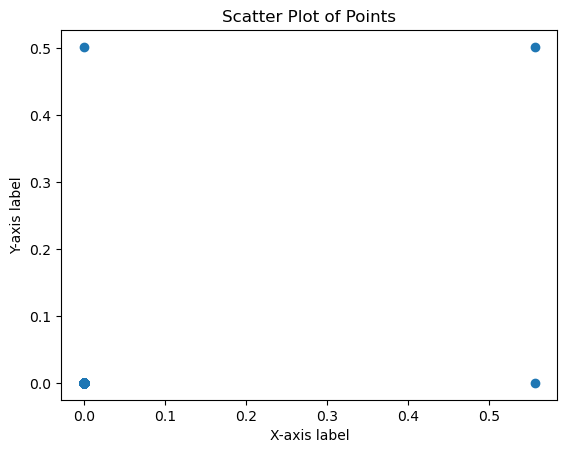

In [ ]:
#SVG coordinates
x, y = zip(*coordinates)
plt.scatter(x, y)

# Add labels and title if needed
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter Plot of Points')
# plt.xlim(4, 557)
# plt.ylim(75, 502)
# Show the plot
plt.show()


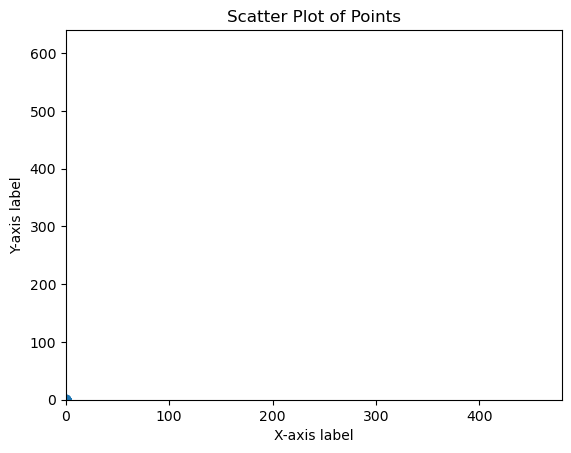

In [ ]:
remapped_x, remapped_y = zip(*remapped)
plt.scatter(remapped_x, remapped_y)

# Add labels and title if needed
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter Plot of Points')

plt.xlim(0, 480)
plt.ylim(0, 640)
# Show the plot
plt.show()


## Comparing  Pre-MAT and Post-MAT Skeletonization

<img src="/pre_skeletonization_plot.png" width="" align="" />

<img src="/post_skeletonization_plot.png" width="" align="" />

## Comparing  Pre-MAT and Post-MAT Skeletonization

### An improved plot of our pre & post-processed bunny from SVG path to MatPlot using svgpath2mpl

<img src="/pre_processed_bunny.png" width="" align="" />

<img src="/post_processed_bunny.png" width="" align="" />

In [ ]:
### CODE TO GENERATE THE ABOVE PLOTS 
#better matplot plotting from SVG Path 
#taken from https://github.com/nvictus/svgpath2mpl
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import HTML, SVG
import numpy as np
from svgpath2mpl import parse_path

svg_path_data_pre = reparsed_data_original['path string']
path_post = parse_path(svg_path_data)
path_pre = parse_path(svg_path_data_pre)

fig, ax = plt.subplots(nrows=1, ncols=1)
patch = mpl.patches.PathPatch(
    path_post, 
    edgecolor='blue', 
    linewidth=1)
patch.set_transform(ax.transData);
ax.add_patch(patch);
ax.set_aspect(1);
ax.set_xlim(300, 550);
ax.set_ylim(480, 300);

ModuleNotFoundError: No module named 'svgpath2mpl'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9651abc2-eeb7-42d8-826f-09f5a16b2834' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>